In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt
from datetime import date, timedelta, datetime
import plotly.graph_objects as go
import plotly.express as px

In [22]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [36]:
d1 = dt.datetime(2022, 12, 30)
end_date = d1
d2 = dt.datetime(2021, 1, 1)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

In [45]:
# Define the ticker

ticker = 'GOOGL'

df = yf.download(ticker,start=start_date, end=end_date, progress=False)

In [46]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,88.000000,88.124496,85.357002,86.306503,86.306503,37324000
2021-01-05,86.254501,87.341499,85.845001,87.002502,87.002502,20360000
2021-01-06,85.013000,87.198502,84.805000,86.143997,86.143997,46588000
2021-01-07,86.337997,88.890999,86.337997,88.717003,88.717003,41936000
2021-01-08,88.858002,89.968002,88.060997,89.891502,89.891502,35484000


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 502 entries, 2021-01-04 to 2022-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       502 non-null    float64
 1   High       502 non-null    float64
 2   Low        502 non-null    float64
 3   Close      502 non-null    float64
 4   Adj Close  502 non-null    float64
 5   Volume     502 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.5 KB


In [49]:
df["Date"] = df.index
df.reset_index(drop=True, inplace=True)
# df.info()

# resetting column sequence
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

In [50]:
# Plotting the data to see trend and seasonality
fig = px.line(df, x='Date', y=df.columns, title="GOOGL Stock Price")
fig.show()

In [51]:
df = df[['Date', 'Close']]
df.head()


,Date,Close
0,0,86.306503
1,1,87.002502
2,2,86.143997
3,3,88.717003
4,4,89.891502


In [52]:
# Plotting the data to see trend and seasonality
fig = px.line(df, x='Date', y='Close', title="GOOGL Stock Price")
fig.show()

In [53]:
df.describe()

,Date,Close
count,502.000000,502.000000
mean,250.500000,119.564332
std,145.059183,17.843401
min,0.000000,83.430000
25%,125.250000,104.352373
50%,250.500000,117.609497
75%,375.750000,136.406506
max,501.000000,149.838501


In [58]:
# Assumptions of ARIMA model
# 1) Stationarity

# Stationarity check on data

def check_stationarity(df):
  result = adfuller(df)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' %result[1])
  if result[1] <= 0.05:
    print("REJECT the null hypothesis. Data is stationary")
  else:
    print("Data is NOT stationary")

In [59]:
check_stationarity(df['Close'])

ADF Statistic: -1.553739
p-value: 0.506780
Data is NOT stationary


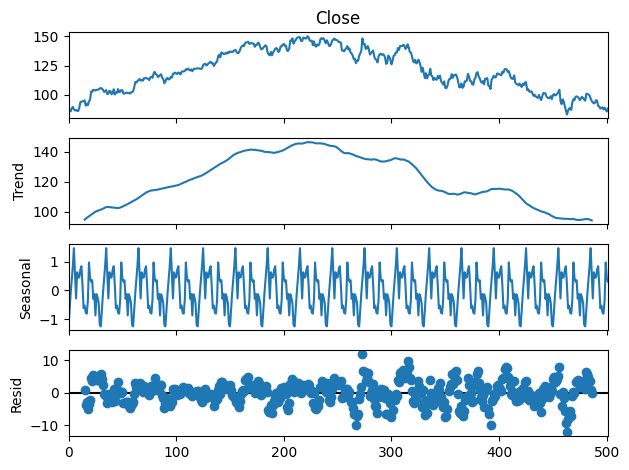

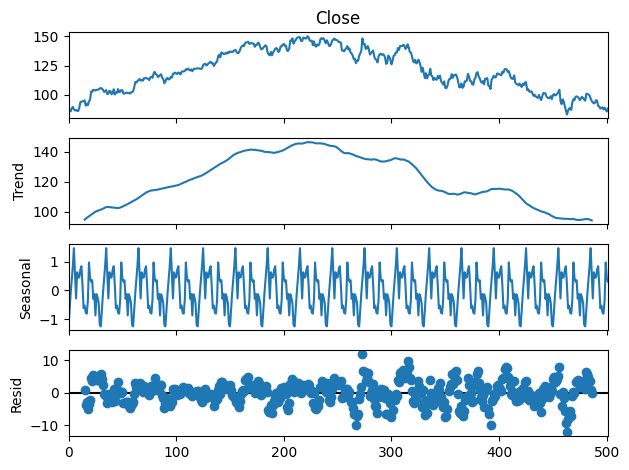

In [61]:
# Decomposing the data to see the trend, seasonality and noise

decompose = seasonal_decompose(df['Close'], model='additive', period=30)
decompose.plot()

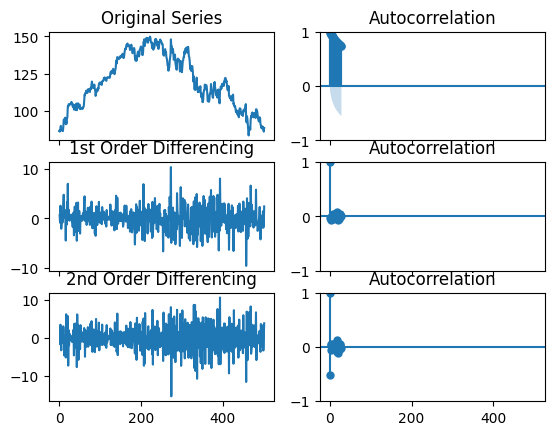

In [64]:
# Original Series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df['Close']); axes[0, 0].set_title('Original Series')
plot_acf(df['Close'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df['Close'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['Close'].diff().dropna(), ax=axes[1,1])

#2nd Differencing
axes[2, 0].plot(df['Close'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df['Close'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

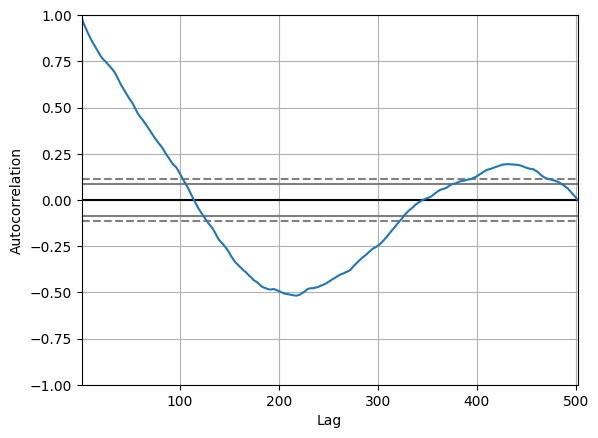

In [65]:
# Since not much difference between d=1 and d=2, we take d=1

# Now lets find p value, i.e. how many lags/previous observations we want to influence the next observation

pd.plotting.autocorrelation_plot(df['Close'])


In [68]:
from statsmodels.tsa.stattools import acf, pacf

x_acf = pd.DataFrame(acf(df['Close']))
print(x_acf)

# We check after how many lags does the auto correlation factor drop below 0.95

           0
0   1.000000
1   0.984816
2   0.969885
3   0.955300
4   0.942835
5   0.930371
6   0.918361
7   0.906449
8   0.895186
9   0.884344
10  0.872817
11  0.862734
12  0.853551
13  0.844543
14  0.835221
15  0.825985
16  0.817377
17  0.807263
18  0.798654
19  0.788680
20  0.780573
21  0.772466
22  0.765627
23  0.759799
24  0.754796
25  0.749232
26  0.743488
27  0.737200


In [69]:
# We can say p = 4
# Now we need to find q value

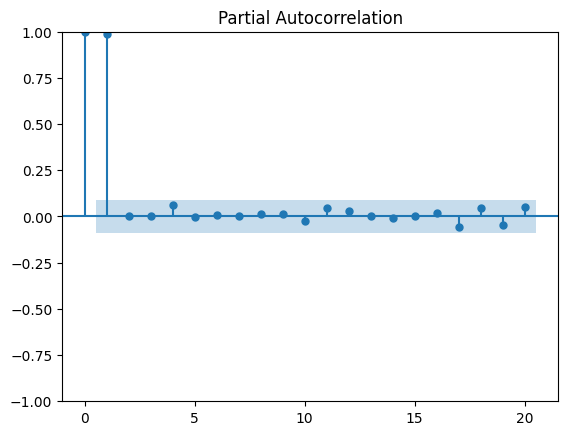

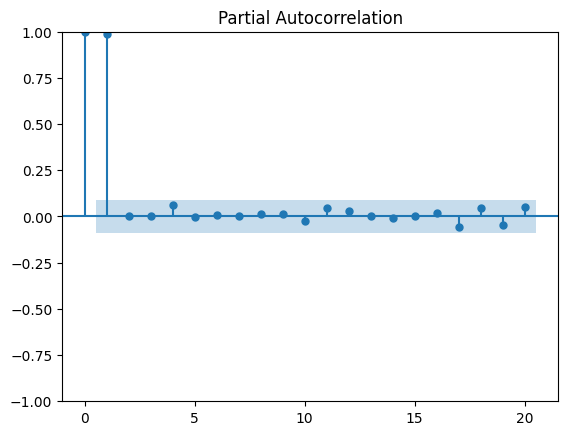

In [72]:
plot_pacf(df['Close'], lags = 20, alpha = 0.05)

In [74]:
# As seen from the graph, the two points are outliers, therefore we take q = 2

# lets define p, d, q

p = 4
d = 1
q = 2

In [76]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.5 MB/s eta 0:00:00


In [78]:
from pmdarima.arima import auto_arima

model = auto_arima(df['Close'], start_p = 1, start_q = 1, max_p = 4, max_q = 2, m=12, start_P = 0, seasonal=True, d = 1, D=1, trace=True, eroor_action='ignore', suppress_warnings=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2585.063, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2423.983, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2585.918, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2373.135, Time=0.66 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.33 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.67 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2372.774, Time=0.75 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=2422.484, Time=0.17 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.02 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.06 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2373.035, Time=0.73 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=2364.525, Time=3.59 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2411.1

In [79]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  502
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 12)   Log Likelihood               -1177.263
Date:                             Sat, 23 Sep 2023   AIC                           2364.525
Time:                                     09:21:35   BIC                           2385.487
Sample:                                          0   HQIC                          2372.759
                                             - 502                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9206      0.028     33.229      0.000       0.866       0.975
ma.L1         -0.9854      

In [82]:
from statsmodels.tsa.arima.model import ARIMA
model_arima = ARIMA(df['Close'], order=(p, d, q))
model_arima = model_arima.fit()
print(model_arima.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  502
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -1136.967
Date:                Sat, 23 Sep 2023   AIC                           2287.933
Time:                        09:28:22   BIC                           2317.450
Sample:                             0   HQIC                          2299.515
                                - 502                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2627      1.210      0.217      0.828      -2.110       2.635
ar.L2          0.3505      0.729      0.481      0.631      -1.079       1.780
ar.L3         -0.0576      0.048     -1.209      0.2

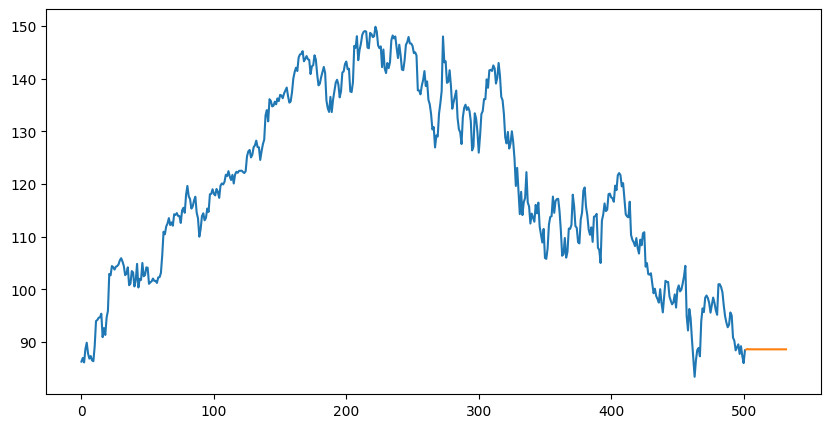

In [84]:
# predict next 30 days

forecast = model_arima.predict(len(df['Close']), len(df['Close'])+30)

plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Actual')
plt.plot(forecast, label='Forecast')

In [93]:
# lets run SARIMA
import statsmodels.api as sm
import warnings

model_sarima = sm.tsa.statespace.SARIMAX(df['Close'], order = (2, d, q), seasonal_order = (2, d, q, 12))

model_sarima = model_sarima.fit()
print(model_sarima.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  502
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -1134.645
Date:                            Sat, 23 Sep 2023   AIC                           2287.290
Time:                                    09:43:32   BIC                           2325.021
Sample:                                         0   HQIC                          2302.109
                                            - 502                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1436      0.218     -0.657      0.511      -0.572       0.285
ar.L2          0.7589      0.158   

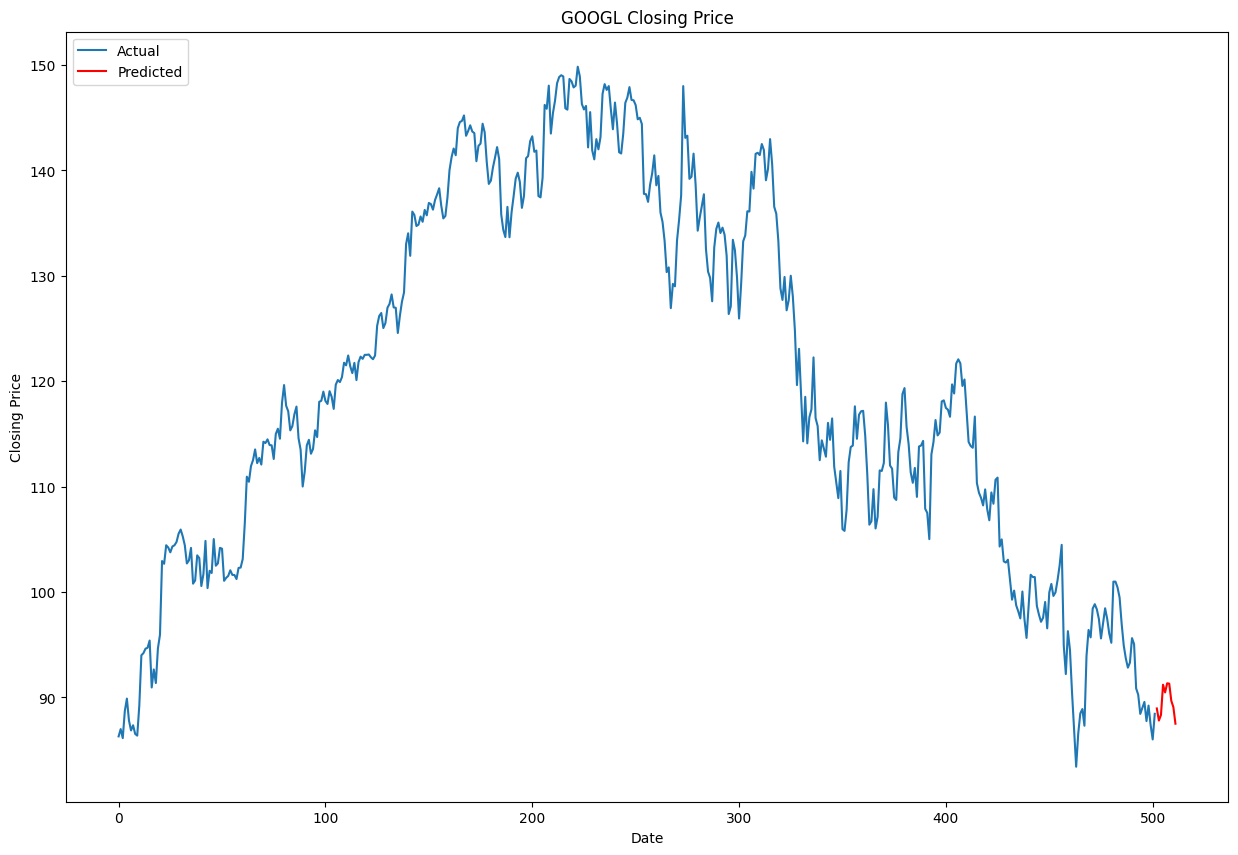

In [95]:
prediction = model.predict(start=len(df['Close']), end =len(df['Close'])+30)

plt.figure(figsize = (15, 10))
plt.plot(df['Close'], label='Actual')
plt.plot(prediction, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('GOOGL Closing Price')
plt.legend(loc='upper left')
plt.show()